# Verification of Lorentz forces in traveling magnetic field (TMF)

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import jv

%matplotlib widget

## Analytical solution

This is based on *K. Dadzis, Modeling of directional solidification of multicrystalline silicon in a traveling magnetic field, PhD Thesis, Technische Universität Bergakademie Freiberg, 2012. http://dx.doi.org/10.13140/RG.2.2.19158.24646, section 2.1.5 and 3.2.3*.

### Horizontal component of Lorentz force

The analytical solution is based on magnetic flux density $B_0$ and wave number $\alpha$ from numerical simulation.

In [53]:
omega = 2*np.pi*500
sigma = 1e6
mu_0 = 4*np.pi*1e-7

def F_L_z(B_0, alpha, r):
    gamma = (alpha**2 + 1j*sigma*mu_0*omega)**0.5
    return alpha * omega * sigma * B_0**2 / (2*np.abs(gamma)**2) * np.abs(  jv(1, gamma*r) / jv(0, gamma*np.max(r))  )**2

def F_L_r(B_0, alpha, r):
    gamma = (alpha**2 + 1j*sigma*mu_0*omega)**0.5
    return - omega*sigma*B_0**2 / (2*np.abs(gamma)**2) * np.imag(gamma * jv(0, gamma * r)* jv(1, np.conj(gamma) * r))/np.abs( jv(0, gamma*np.max(r)))**2

## Numerical simulation

See *simulation.py*. Data was extracted using ParaView *plot over line* and *save data* on a horizontal line in the cylinder center and on a vertical line on the cylinder surface

In [44]:
df_horizontal = pd.read_csv("paraview_horizontal-line.csv")
df_horizontal = df_horizontal.sort_values("Points:0")
df_vertical = pd.read_csv("paraview_vertical-line.csv")
df_vertical = df_vertical.sort_values("Points:1")

In [45]:
df_sorted = df_horizontal.sort_values("Points:0", ascending=False)
print("Vertical component of mag. flux density at cylinder center on surface")
B_re = df_sorted.iloc[0]["magnetic flux density re e:1"]
B_im = df_sorted.iloc[0]["magnetic flux density im e:1"]
B_0 = (B_re**2 + B_im**2)**0.5
print("re:", B_re*1e3, "mT")
print("im:", B_im*1e3, "mT")
print("abs:", B_0*1e3, "mT")

Vertical component of mag. flux density at cylinder center on surface
re: -3.4196999999999997 mT
im: 2.0206 mT
abs: 3.9720488982387923 mT


In [46]:
# compute lorentz force in cylinder center
lorentz_force = []
for index, row in df_horizontal.iterrows():
    fl = 0.5 * (
                np.cross(
                    [row["current density re e:0"], row["current density re e:1"], row["current density re e:2"]],
                    [-row["magnetic flux density re e:0"], -row["magnetic flux density re e:1"], -row["magnetic flux density re e:2"]],  # correct direction of B
                )
                + np.cross(
                    [row["current density im e:0"], row["current density im e:1"], row["current density im e:2"]],
                    [-row["magnetic flux density im e:0"], -row["magnetic flux density im e:1"], -row["magnetic flux density im e:2"]],  # correct direction of B
                )
    )
    lorentz_force.append((fl[0]**2 + fl[1]**2 + fl[2]**2)**0.5)
df_horizontal["lorentz force"] = lorentz_force

# compute phase angle at cylinder surface
phase_angle = []
for index, row in df_vertical.iterrows():
    phi = np.arctan(row["magnetic flux density im e:1"] / row["magnetic flux density re e:1"]) / (2*np.pi) * 360
    phase_angle.append(phi)
df_vertical["phase angle"] = phase_angle

# compute EM wave number (in two different ways)
alpha_1 = []
alpha_2 = []
for i in range(len(df_vertical) - 1):
    row = df_vertical.iloc[i]
    next_row = df_vertical.iloc[i+1]
    d_y = next_row["Points:1"] - row["Points:1"]
    d_B_im = next_row["magnetic flux density im e:1"] - row["magnetic flux density im e:1"]
    d_B_re = next_row["magnetic flux density re e:1"] - row["magnetic flux density re e:1"]
    B_im = row["magnetic flux density im e:1"]
    B_re = row["magnetic flux density re e:1"]
    alpha_1.append(
        (d_B_im / d_y * B_re - B_im * d_B_re / d_y) / (B_re**2 + B_im**2)
    )
    d_phi = (next_row["phase angle"] - row["phase angle"])/360 * 2 * np.pi
    alpha_2.append(d_phi / d_y)
alpha_1.append(alpha_1[-1])
alpha_2.append(alpha_2[-1])
df_vertical["alpha 1"] = alpha_1
df_vertical["alpha 2"] = alpha_2

# evaluate alpha at cylinder surface, around x=0
delta_z = 0.01
df_center = df_vertical.loc[(df_vertical["Points:1"] >= - delta_z/2) & (df_vertical["Points:2"] <= delta_z/2)]
alpha_mean = df_center["alpha 1"].mean()
print(f"Average wave number: {alpha_mean:.2f}")

Average wave number: 9.27


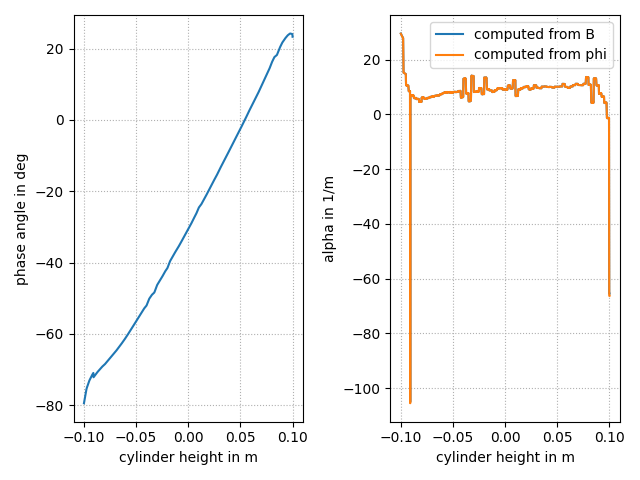

In [47]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(df_vertical["Points:1"], df_vertical["phase angle"])
ax[0].set_xlabel("cylinder height in m")
ax[0].set_ylabel("phase angle in deg")
ax[0].grid(linestyle=":")
ax[1].plot(df_vertical["Points:1"], df_vertical["alpha 1"], label="computed from B")
ax[1].plot(df_vertical["Points:1"], df_vertical["alpha 2"], label="computed from phi")
ax[1].legend()
ax[1].set_xlabel("cylinder height in m")
ax[1].set_ylabel("alpha in 1/m")
ax[1].grid(linestyle=":")
fig.tight_layout()

## Comparison

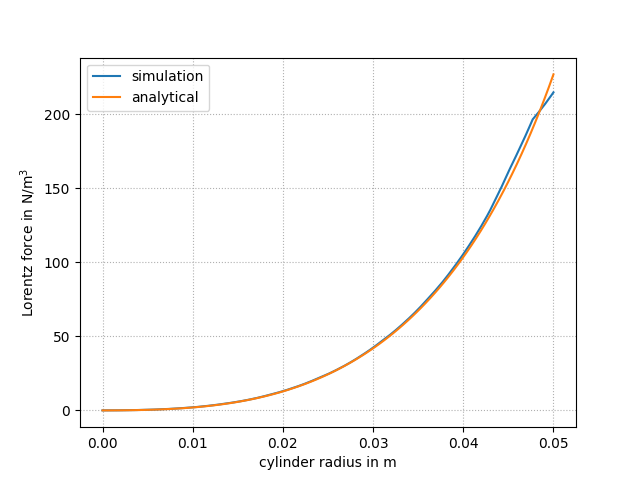

In [56]:
fig, ax = plt.subplots()
ax.plot(df_horizontal["Points:0"], df_horizontal["lorentz force"], label="simulation")
r = np.linspace(0, 0.05, 100)
F_l = (F_L_r(B_0, alpha_mean, r)**2 + F_L_z(B_0, alpha_mean, r)**2)**0.5
ax.plot(r, F_l, label="analytical")
ax.set_xlabel("cylinder radius in m")
ax.set_ylabel("Lorentz force in N/$\mathrm{m}^3$")
ax.grid(linestyle=":")
ax.legend();